## BlackSheep Cookbook Exploration

The Black Sheep Analysis allows researchers to find trends in abnormal protein enrichment among patients in CPTAC datasets. In this Cookbook, we will go through the steps needed to perform a full Black Sheep Analysis.

### Step 1a: Import Dependencies
First, import the necessary dependencies and load cptac data.

In [2]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import cptac
import binarization_functionsCopy as bf
import blackSheepCPTACmoduleCopy as blsh
import gseapy as gp
from gseapy.plot import barplot, heatmap, dotplot
import requests
import json

## Step 1b: Load Data and Choose Omics Table
For this analysis, we will be looking at results across the proteomics, transcriptomics, and phosphoproteomics tables.

In [3]:
cptac.download(dataset='endometrial')

True

In [4]:
en = cptac.Endometrial()
proteomics = en.get_proteomics()
transcriptomics = en.get_transcriptomics()
clinical = en.get_clinical()

In [5]:
#Append Genomics_subtype and MSI_status to clinical table
df= en.get_derived_molecular()
clinical['MSI_status'] = df['MSI_status']
clinical['Genomics_subtype'] = df['Genomics_subtype']

## Step 2: Determine what attributes you would like to A/B test. 
For this analysis, we will iteratively go through the various columns in the clinical dataset, to determine if any of them have trends within them for protein enrichment.

In [6]:
#Create a copy of the original Clinical DataFrame and drop irrelevant columns.
annotations = pd.DataFrame(clinical.copy())
annotations = annotations.drop(['Patient_ID', 
                                'Treatment_naive', 
                                'Tumor_purity', 
                                'Gender', 
                                'Tumor_Site_Other'], axis=1)

## Step 2a: Binarize column values

In [7]:
tumor_map = {'Tumor':'Normal_Tumor', 
             'Adjacent_normal':'Other_tumor', 
             'Enriched_normal':'Other_tumor', 
             'Myometrium_normal':'Other_tumor'}

annotations['Proteomics_Tumor_Normal'] = bf.binarizeCategorical(clinical, 
                                                                'Proteomics_Tumor_Normal', 
                                                                tumor_map)

In [8]:
country_map = {'United States':'US', 
               'Ukraine':'Other', 
               'Other_specify':'Other', 
               'Poland':'Other'}

annotations['Country'] = bf.binarizeCategorical(clinical, 
                                                'Country', 
                                                country_map)

In [9]:
annotations['BMI'] = bf.binarizeRange(clinical, 'BMI', 18, 25, 
                                      'Healthy', 'Unhealthy')

annotations['Age'] = bf.binarizeCutOff(clinical, 'Age', 
                                       60.0, 'Old', 'Young')

In [10]:
FIGO_map = {'FIGO grade 1':'Low_grade', 
            'FIGO grade 2':'High_grade', 
            'FIGO grade 3':'High_grade'}

annotations['Histologic_Grade_FIGO'] = bf.binarizeCategorical(clinical, 
                                                              'Histologic_Grade_FIGO', 
                                                              FIGO_map)

In [11]:
Myo_map = {'under 50 %':'under_50%', 
           '50 % or more': '50%_or_more', 
           'Not identified': 'under_50%'}

annotations['Myometrial_invasion_Specify'] = bf.binarizeCategorical(clinical, 
                                                                    'Myometrial_invasion_Specify', 
                                                                    Myo_map)

In [12]:
path_tumor_map = {'pT1a (FIGO IA)':'Not_FIGO_III', 
            'pT1b (FIGO IB)':'Not_FIGO_III', 
            'pT2 (FIGO II)':'Not_FIGO_III', 
            'pT1 (FIGO I)':'Not_FIGO_III', 
            'pT3a (FIGO IIIA)':'FIGO_III', 
            'pT3b (FIGO IIIB)':'FIGO_III'}

annotations['Path_Stage_Primary_Tumor-pT'] = bf.binarizeCategorical(clinical, 
                                                                    'Path_Stage_Primary_Tumor-pT', 
                                                                    path_tumor_map)

In [13]:
path_lymph_map = {'pN0':'Not_FIGO_III', 
                  'pNX':'Not_FIGO_III', 
                  'pN1 (FIGO IIIC1)':'FIGO_III', 
                  'pN2 (FIGO IIIC2)':'FIGO_III'}

annotations['Path_Stage_Reg_Lymph_Nodes-pN'] = bf.binarizeCategorical(clinical, 
                                                                      'Path_Stage_Reg_Lymph_Nodes-pN', 
                                                                      path_lymph_map)

In [14]:
clin_stage_map = {'cM0':'cM0_or_cM1', 
                  'cM1':'cM0_or_cM1', 
                  'Staging Incomplete':'Staging_Incomplete'}

annotations['Clin_Stage_Dist_Mets-cM'] = bf.binarizeCategorical(clinical, 
                                                                'Clin_Stage_Dist_Mets-cM', 
                                                                clin_stage_map)

In [15]:
path_stage_map = {'Staging Incomplete': 'No_distant_metastasis', 
                  'No pathologic evidence of distant metastasis':'No_distant_metastasis', 
                  'pM1':'Distant_Metastasis'}

annotations['Path_Stage_Dist_Mets-pM'] = bf.binarizeCategorical(clinical, 
                                                                'Path_Stage_Dist_Mets-pM', 
                                                                path_stage_map)

In [16]:
tumor_stage_map = {'Stage I':'Stage_I_or_II', 
                   'Stage II':'Stage_I_or_II', 
                   'Stage III':'Stage_III_or_IV', 
                   'Stage IV':'Stage_III_or_IV'}

annotations['tumor_Stage-Pathological'] = bf.binarizeCategorical(clinical, 
                                                               'tumor_Stage-Pathological', 
                                                               tumor_stage_map)

In [17]:
FIGO_stage_map = {'IA':'I_or_II', 
                  'IB':'I_or_II', 
                  'II':'I_or_II', 
                  'IIIA':'III_or_IV', 
                  'IIIC1':'III_or_IV', 
                  'IVB':'III_or_IV', 
                  'IIIC2':'III_or_IV', 
                  'IIIB':'III_or_IV'}

annotations['FIGO_stage'] = bf.binarizeCategorical(clinical, 
                                                   'FIGO_stage', 
                                                   FIGO_stage_map)

In [18]:
diabetes_map = {'No':'No', 
                'Yes':'Yes', 
                'Unknown':'No'}

annotations['Diabetes'] = bf.binarizeCategorical(clinical, 
                                                 'Diabetes', 
                                                 diabetes_map)

In [19]:
race_map = {'White':'White', 
            'Black or African American':'Not_White', 
            'Asian':'Not_White', 
            'Not Reported':'Not_White'}

annotations['Race'] = bf.binarizeCategorical(clinical, 
                                             'Race', 
                                             race_map)

In [20]:
ethnicity_map = {'Not-Hispanic or Latino':'Not_Hispanic', 
                 'Not reported':'Not_Hispanic', 
                 'Hispanic or Latino':'Hispanic'}

annotations['Ethnicity'] = bf.binarizeCategorical(clinical, 
                                                  'Ethnicity', 
                                                  ethnicity_map)

In [21]:
tumor_site_map = {'Other, specify':'Not_Anterior', 
                  'Anterior endometrium':'Anterior', 
                  'Posterior endometrium':'Not_Anterior'}

annotations['Tumor_Site'] = bf.binarizeCategorical(clinical, 
                                                   'Tumor_Site', 
                                                   tumor_site_map)

In [22]:
annotations['Tumor_Size_cm'] = bf.binarizeCutOff(clinical, 
                                                'Tumor_Size_cm', 4.0, 
                                                'Large_tumor', 
                                                'Small_tumor')

In [23]:
num_pregnancies_map = {2:'Less_than_3', 
                       1:'Less_than_3', 
                       'None':'Less_than_3', 
                       None:'Less_than_3', 
                       3:'3_or_more', 
                       '4 or more':'3_or_more'}

annotations['Num_full_term_pregnancies'] = bf.binarizeCategorical(clinical, 
                                                                  'Num_full_term_pregnancies', 
                                                                  num_pregnancies_map)

In [24]:
genomics_map = {'MSI-H':'MSI-H', 
                'CNV_low':'Other_subtype', 
                'CNV_high':'Other_subtype', 
                'POLE':'Other_subtype'}

annotations['Genomics_subtype'] = bf.binarizeCategorical(clinical, 
                                                         'Genomics_subtype', 
                                                         genomics_map)

## Step 3: Perform outliers analysis

In [32]:
outliers_prot = blsh.make_outliers_table(transcriptomics, iqrs=1.5, 
                                         up_or_down='up', 
                                         aggregate=False, 
                                         frac_table=False)

In [33]:
length = int(len(outliers_prot.index) / 2)
only_outliers_up_prot = outliers_prot[:length]
outlier_up_prot_dict = {}
for i in range(length):
    key = proteomics.index[i]
    my_filter = only_outliers_up_prot.iloc[i] == 1.0
    value = list(only_outliers_up_prot.iloc[i][my_filter].index)
    outlier_up_prot_dict[key] = value

## Step 4: Wrap your A/B test into the outliers analysis, and create a table

In [34]:
results_prot = blsh.compare_groups_outliers(outliers_prot, 
                                            annotations)

Many of the output values from compare_group_outliers are NaN, so here we will get rid of the NaN values for visualization purposes.

In [35]:
results_prot = results_prot.dropna(axis=0, how='all')

In [36]:
sig_cols = []
for col in results_prot.columns:
    sig_col = bf.significantEnrichments(results_prot, col, 0.01)
    if sig_col is not None and len(sig_col) > 5:
        sig_cols.append(sig_col)
    else:
        results_prot = results_prot.drop(col, axis=1)

## Step 5: Visualize these enrichments

C:\Users\Daniel\AppData\Local\conda\conda\envs\Research\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """Entry point for launching an IPython kernel.


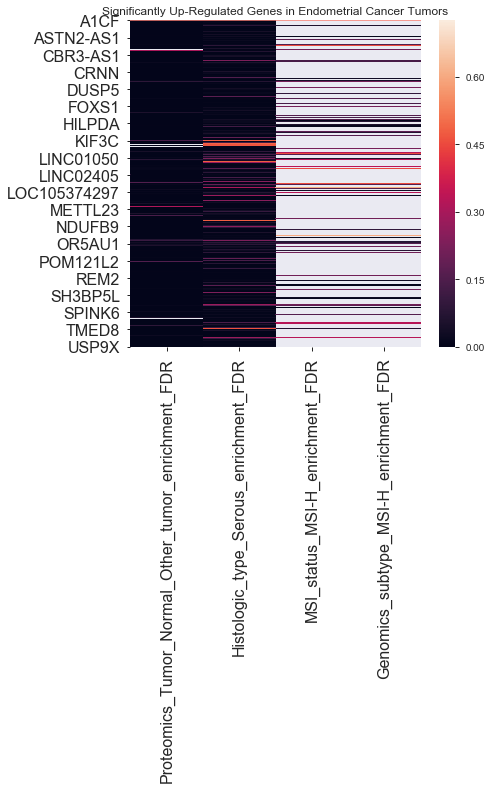

In [37]:
axis = plt.axes()
sns.heatmap(results_prot, ax = axis)
axis.set_title("Significantly Up-Regulated Genes in Endometrial Cancer Tumors")
plt.show()

## Step 6: Perform Gene Set Enrichment Analysis

In [31]:
for col in sig_cols:
    col_name = col.columns[0]
    gene_name_list = list(col.index)
    enrichment = gp.enrichr(gene_list = gene_name_list, 
                            description=col_name, 
                            gene_sets='KEGG_2019_Human',
                            outdir='test/endometrial')
    print(enrichment.res2d)
    barplot(enrichment.res2d, title=col_name)

2019-09-05 17:44:02,970 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


           Gene_set                                             Term Overlap  \
0   KEGG_2019_Human                                      Endocytosis   2/244   
1   KEGG_2019_Human                    Glycosaminoglycan degradation    1/19   
2   KEGG_2019_Human         Pentose and glucuronate interconversions    1/34   
3   KEGG_2019_Human                                      Ferroptosis    1/40   
4   KEGG_2019_Human             Porphyrin and chlorophyll metabolism    1/42   
5   KEGG_2019_Human                               Mineral absorption    1/51   
6   KEGG_2019_Human            Regulation of lipolysis in adipocytes    1/55   
7   KEGG_2019_Human                  Fc epsilon RI signaling pathway    1/68   
8   KEGG_2019_Human                  Adipocytokine signaling pathway    1/69   
9   KEGG_2019_Human                           ErbB signaling pathway    1/85   
10  KEGG_2019_Human                           GnRH signaling pathway    1/93   
11  KEGG_2019_Human                T cel

[159 rows x 10 columns]


2019-09-05 17:44:11,902 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


          Gene_set                                      Term Overlap  \
0  KEGG_2019_Human   Glyoxylate and dicarboxylate metabolism    1/30   
1  KEGG_2019_Human  Glycine, serine and threonine metabolism    1/40   
2  KEGG_2019_Human                             RNA transport   1/165   

    P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0  0.011939               1.0            0                     0   83.333333   
1  0.015891               1.0            0                     0   62.500000   
2  0.064136               1.0            0                     0   15.151515   

   Combined Score Genes  
0      368.994341  GLDC  
1      258.874854  GLDC  
2       41.617414  XPO5  


## Step 7: Connect findings with the Genome Druggable Interactive Database (DGIdb)

Our goal is to find personalized medicines based on specific clinical attributes, for individual patients, and to see how their current medicines are helping, hurting, or are indifferent towards their cancer treatment.

## Step 7a: Personalized Medicine by Clinical Attributes
After performing our outlier analyses, we find that there are groups of patients that have a common set of significantly up or down regulated genes grouped by clinical attributes. Here we will use those groups to find drugs best suited to both bring those gene enrichments to normal levels, and aid in the treatment of their cancer

First, we will perform HTTP GET requests to DGIdb for all of our significantly up-regulated genes by clinical attribute.  Note, that we will want to look for drugs with an interaction type of 'inhibitor' for up-regulated genes.

In [31]:
#Here we will link clinical attributes with significantly up-regulated genes
sig_genes_up = {}
for i, col in enumerate(sig_cols):
    list_of_genes = list(col.index)
    sig_genes_up[sig_cols[i].columns[0][:-9]] = list_of_genes

This will perform a general HTTP GET request to DGIdb.  While this is fast, it would be worthwile to search specifically for drugs that are inhibitors to patients' significantly up-regulated genes, so we will compare both queries below.

In [32]:
#General GET Request
requests_up = list(map(bf.dgidb_get_request, sig_genes_up.values()))

In [33]:
print('UP-REGULATED GENERAL REQUEST:\n')
drug_dict_up = {}
for i, request in enumerate(requests_up):
    clinical_attribute = sig_cols[i].columns[0][:-9]
    drug_dict_up[clinical_attribute] = bf.dgidb_json_parse(request, genes=True)
print(json.dumps(drug_dict_up, indent=4), '\n')

UP-REGULATED GENERAL REQUEST:

{
    "Proteomics_Tumor_Normal_Other_tumor": {
        "FTH1": {
            "IRON DEXTRAN": [
                "other"
            ]
        },
        "GNLY": {
            "MYELOPEROXIDASE": []
        },
        "MAP2K7": {
            "COBIMETINIB": [
                "allosteric modulator",
                "inhibitor"
            ],
            "Refametinib": [
                "inhibitor"
            ],
            "TRAMETINIB": [
                "inhibitor"
            ],
            "AZD-8330": [
                "inhibitor"
            ],
            "SELUMETINIB": [
                "inhibitor"
            ],
            "PD-0325901": [
                "inhibitor"
            ],
            "DABRAFENIB MESYLATE": [
                "inhibitor"
            ],
            "BINIMETINIB": [
                "inhibitor"
            ],
            "IODOACETAMIDE": [
                "inhibitor"
            ],
            "WX-554": []
        },
        "NPY"

} 



In [34]:
inhibitors = []
for genes in sig_genes_up.values():
    inhibitors.append(bf.dgidb_get_request(genes, interaction_types=['inhibitor']))

In [35]:
print('UP-REGULATED INHIBITORS:\n')
inhibitor_dict = {}
for i, request in enumerate(requests_up):
    clinical_attribute = sig_cols[i].columns[0][:-9]
    inhibitor_dict[clinical_attribute] = bf.dgidb_json_parse(request, genes=True)
print(json.dumps(inhibitor_dict, indent=4))

UP-REGULATED INHIBITORS:

{
    "Proteomics_Tumor_Normal_Other_tumor": {
        "FTH1": {
            "IRON DEXTRAN": [
                "other"
            ]
        },
        "GNLY": {
            "MYELOPEROXIDASE": []
        },
        "MAP2K7": {
            "COBIMETINIB": [
                "allosteric modulator",
                "inhibitor"
            ],
            "Refametinib": [
                "inhibitor"
            ],
            "TRAMETINIB": [
                "inhibitor"
            ],
            "AZD-8330": [
                "inhibitor"
            ],
            "SELUMETINIB": [
                "inhibitor"
            ],
            "PD-0325901": [
                "inhibitor"
            ],
            "DABRAFENIB MESYLATE": [
                "inhibitor"
            ],
            "BINIMETINIB": [
                "inhibitor"
            ],
            "IODOACETAMIDE": [
                "inhibitor"
            ],
            "WX-554": []
        },
        "NPY": {
 

}


## Step 7b: Compare patients' significant genes with the drugs they are currently taking

In [36]:
list(clinical.columns)

['Patient_ID',
 'Proteomics_Tumor_Normal',
 'Country',
 'Histologic_Grade_FIGO',
 'Myometrial_invasion_Specify',
 'Histologic_type',
 'Treatment_naive',
 'Tumor_purity',
 'Path_Stage_Primary_Tumor-pT',
 'Path_Stage_Reg_Lymph_Nodes-pN',
 'Clin_Stage_Dist_Mets-cM',
 'Path_Stage_Dist_Mets-pM',
 'tumor_Stage-Pathological',
 'FIGO_stage',
 'LVSI',
 'BMI',
 'Age',
 'Diabetes',
 'Race',
 'Ethnicity',
 'Gender',
 'Tumor_Site',
 'Tumor_Site_Other',
 'Tumor_Focality',
 'Tumor_Size_cm',
 'Num_full_term_pregnancies',
 'MSI_status',
 'Genomics_subtype']

In [37]:
'''
This cell is not working because I need to still connect the drugs that patients
are taking with the clinical dataframe somehow. I'll need to merge dataframes
most likely.  Additionally, I will probably need to rework my function to include
an arg for medication_col_name or something like that to work on multiple datasets
and not just for Renal
'''
#patient_drugs_genes_up = bf.compare_enrichments_with_drugs(outlier_up_prot_dict, clinical)

"\nThis cell is not working because I need to still connect the drugs that patients\nare taking with the clinical dataframe somehow. I'll need to merge dataframes\nmost likely.  Additionally, I will probably need to rework my function to include\nan arg for medication_col_name or something like that to work on multiple datasets\nand not just for Renal\n"

In [38]:
follow_up_df = pd.read_excel('CPTAC3_Uterine_FollowUp_Outcome_8_12.xlsx')

In [39]:
follow_up_df['Other New Tumor Procedure']

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     NaN
7     NaN
8     NaN
9     NaN
10    NaN
11    NaN
12    NaN
13    NaN
14    NaN
15    NaN
16    NaN
17    NaN
18    NaN
19    NaN
20    NaN
21    NaN
22    NaN
23    NaN
24    NaN
25    NaN
26    NaN
27    NaN
28    NaN
29    NaN
       ..
365   NaN
366   NaN
367   NaN
368   NaN
369   NaN
370   NaN
371   NaN
372   NaN
373   NaN
374   NaN
375   NaN
376   NaN
377   NaN
378   NaN
379   NaN
380   NaN
381   NaN
382   NaN
383   NaN
384   NaN
385   NaN
386   NaN
387   NaN
388   NaN
389   NaN
390   NaN
391   NaN
392   NaN
393   NaN
394   NaN
Name: Other New Tumor Procedure, Length: 395, dtype: float64

In [40]:
living_filter = follow_up_df['Vital Status'] == 'Living'

In [41]:
living_follow_up = follow_up_df[living_filter]

In [42]:
deceased_follow_up = follow_up_df[~living_filter]

In [43]:
deceased_follow_up.iloc[3]

Case ID                                                           C3L-02894
Follow-up Period                                                  12 Months
Lost to Follow-up?                                                       No
Vital Status                                                       Deceased
Path Diag to Last Contact(Day)                                          428
Cause of Death                                                          NaN
Path Diag to Death(days)                                                431
Adj Post-Op Radiation Therapy                                           Yes
Adj Post-Op Pharma Therapy                                              Yes
Adj Post-Op Immunotherapy                                                No
Tumor Status                                                     With Tumor
Menopausal Hormone Therapy                                          Unknown
Oral Contraceptives                                                 Unknown
Tamoxifen   

In [44]:
persistent_filter = follow_up_df['Success of Initial Treatment'] == 'Persistent Disease'

In [45]:
persistent_disease = follow_up_df[persistent_filter]

In [46]:
df = pd.read_csv('https://raw.githubusercontent.com/ruggleslab/blacksheep_supp/dev/vignettes/brca/phospho_common_samples_data.csv')

In [50]:
other = pd.read_csv('https://raw.githubusercontent.com/ruggleslab/blacksheep_supp/dev/vignettes/brca/annotations_common_samples.csv')

(76, 24)